In [15]:
import os
import numpy as np
from pathlib import Path
from scipy.ndimage import convolve
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

# Gabor Filter Kernel
def gabor_kernel(ksize=21, sigma=5.0, theta=0.0, lambd=10.0, gamma=0.5, psi=0):
    kernel_size = ksize if ksize % 2 != 0 else ksize + 1  # Ensure kernel size is odd
    sigma_x, sigma_y = sigma, sigma / gamma
    xmax, ymax = kernel_size // 2, kernel_size // 2
    x, y = np.meshgrid(np.arange(-xmax, xmax+1), np.arange(-ymax, ymax+1))

    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb_kernel = np.exp(-0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * x_theta / lambd + psi)
    return gb_kernel

# GhostNet-like Filter (Lightweight Conv)
def ghostnet_filter(image, kernel_size=3):
    input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    input_tensor = tf.expand_dims(input_tensor, axis=0)  # Add batch dimension
    input_tensor = tf.expand_dims(input_tensor, axis=-1) # Add channel dimension
    depthwise_conv = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=1, padding='same')(input_tensor)
    return depthwise_conv

# Apply Gabor filter using PIL and numpy
def apply_gabor_filter_pil(image, kernel):
    if image.mode != 'L':  # Convert to grayscale if not already
        image = image.convert('L')
    img_array = np.array(image)
    filtered_img = convolve(img_array, kernel)
    return Image.fromarray(np.uint8(filtered_img))

# Apply both Gabor and GhostNet filters
def apply_both_filters(image, gabor_kernel):
    gabor_filtered = apply_gabor_filter_pil(image, gabor_kernel)
    image_array = np.array(gabor_filtered)
    ghostnet_filtered = ghostnet_filter(image_array)
    return Image.fromarray(np.uint8(ghostnet_filtered.numpy().squeeze()))

# Preprocess and save images while keeping original folder structure
def preprocess_and_save_images(input_dir, output_dir, image_size=(224, 224)):
    gabor_kernel_ = gabor_kernel()
    
    for root, subdirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(root, file)
                
                # Maintain the same folder structure in the output directory
                relative_path = os.path.relpath(root, input_dir)
                output_folder = os.path.join(output_dir, relative_path)
                Path(output_folder).mkdir(parents=True, exist_ok=True)

                try:
                    # Load and preprocess image
                    image = Image.open(input_path).resize(image_size)
                    filtered_image = apply_both_filters(image, gabor_kernel_)
                    
                    # Save processed image
                    output_path = os.path.join(output_folder, file)
                    filtered_image.save(output_path)
                    print(f"✅ Processed {file}, saved to {output_path}")
                except Exception as e:
                    print(f"❌ Error processing {file}: {e}")

# Example usage
input_directory = 'E:/lung_colon_image_set'  # Replace with your dataset directory
output_directory = 'E:/preprocessed_dataset'  # Preprocessed dataset directory

# Step 1: Preprocess and save images while keeping the folder structure
preprocess_and_save_images(input_directory, output_directory)


✅ Processed colonca1.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1.jpeg
✅ Processed colonca10.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca10.jpeg
✅ Processed colonca100.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca100.jpeg
✅ Processed colonca1000.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1000.jpeg
✅ Processed colonca1001.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1001.jpeg
✅ Processed colonca1002.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1002.jpeg
✅ Processed colonca1003.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1003.jpeg
✅ Processed colonca1004.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1004.jpeg
✅ Processed colonca1005.jpeg, saved to E:/preprocessed_dataset\colon_image_sets\colon_aca\colonca1005.jpeg
✅ Processed colonca1006.jpeg, saved to E:/preproc

In [3]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model
import json  # For saving label map correctly

# Define the Ghost Module
def ghost_module(x, out_channels, ratio=2):
    """Implements the Ghost Module for lightweight feature extraction."""
    init_channels = out_channels // ratio
    cheap_channels = out_channels - init_channels

    # Primary convolution
    primary_conv = layers.Conv2D(init_channels, (1,1), strides=(1,1), padding="same", activation="relu")(x)
    
    # Cheap operation (Depthwise convolution)
    cheap_operation = layers.DepthwiseConv2D((3,3), strides=(1,1), padding="same", activation="relu", depth_multiplier=1)(primary_conv)

    # Merge features
    output = layers.Concatenate()([primary_conv, cheap_operation])
    return output

# Define GhostNet Feature Extractor
def ghostnet_feature_extractor(input_shape=(224, 224, 1)):
    """Builds a simplified GhostNet feature extractor."""
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
    x = ghost_module(x, 32)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = ghost_module(x, 64)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = ghost_module(x, 128)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)  # Feature
    model = Model(inputs, x, name="GhostNet_FeatureExtractor")
    return model

# Load GhostNet model
ghostnet_model = ghostnet_feature_extractor()
ghostnet_model.summary()

# Image preprocessing function
def preprocess_image(image_path, image_size=(224, 224)):
    """Loads and preprocesses an image (resize, normalize, add channel)."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize(image_size)
    image_array = np.array(image) / 255.0  # Normalize to [0,1]
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    return image_array

# Extract features from dataset
def extract_features(input_dir, output_feature_file="features.npy", output_label_file="labels.npy", output_label_map="label_map.json"):
    """Extracts features from dataset using GhostNet and saves them."""
    
    features = []  # Fix: initialize lists correctly
    labels = []    # Fix: initialize lists correctly
    label_map = {}  # Store label mapping
    label_index = 0

    for root, subdirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(root, file)
                
                # Extract class label from folder name
                relative_path = os.path.relpath(root, input_dir)
                if relative_path not in label_map:
                    label_map[relative_path] = label_index
                    label_index += 1
                
                # Load and preprocess image
                image_array = preprocess_image(image_path)
                image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
                
                # Extract feature vector using GhostNet
                feature_vector = ghostnet_model.predict(image_array, verbose=0)
                
                # Store feature and label
                features.append(feature_vector.flatten())  # Flatten to 1D
                labels.append(label_map[relative_path])

    # Convert to numpy arrays and save
    np.save(output_feature_file, np.array(features))
    np.save(output_label_file, np.array(labels))

    # Save label map correctly as JSON
    with open(output_label_map, "w") as json_file:
        json.dump(label_map, json_file)

    print(f"✅ Feature extraction complete! Features saved to {output_feature_file}, Labels saved to {output_label_file}")
    print(f"Label Mapping saved to {output_label_map}: {label_map}")



Model: "GhostNet_FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 224, 224, 16)         160       ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 224, 224, 16)         272       ['conv2d_8[0][0]']            
                                                                                                  
 depthwise_conv2d_6 (Depthw  (None, 224, 224, 16)         160       ['conv2d_9[0][0]']            
 iseConv2D)                                                               

In [2]:
%pip freeze > req.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip --version

pip 24.0 from D:\anconda\Lib\site-packages\pip (python 3.11)

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install timm

     ---------------------------------------- 0.0/52.0 kB ? eta -:--:--
     -------------- ----------------------- 20.5/52.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 52.0/52.0 kB 663.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.4 MB 5.3 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.4 MB 6.3 MB/s eta 0:00:01
   --------------- ------------------------ 0.9/2.4 MB 7.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.3/2.4 MB 7.7 MB/s eta 0:00:01
   --------------------------- ------------ 1.6/2.4 MB 7.5 MB/s eta 0:00:01
   --------------------------------- ------ 2.0/2.4 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------  2.4/2.4 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/469.0 kB ? eta -:--:--
   -----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os

# Set CPU optimization variables BEFORE importing TensorFlow
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "6"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "6"

import tensorflow as tf

print("✅ Running TensorFlow optimized for CPU.")


✅ Running TensorFlow optimized for CPU.


In [3]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
import json

# Define the GhostNet-based Feature Extractor
def ghostnet_feature_extractor():
    inputs = tf.keras.Input(shape=(224, 224, 1))
    
    x = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3,3), activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(32, (1,1), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

    x = tf.keras.layers.DepthwiseConv2D((3,3), activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, (1,1), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

    x = tf.keras.layers.DepthwiseConv2D((3,3), activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, (1,1), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)  # Feature vector

    model = Model(inputs, x, name="GhostNet_FeatureExtractor")
    return model

# Load the feature extractor
ghostnet_model = ghostnet_feature_extractor()
ghostnet_model.summary()

# Image Preprocessing Function
def preprocess_image(image_path, image_size=(224, 224)):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize(image_size)
    image_array = np.array(image) / 255.0  # Normalize to [0,1]
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    return image_array

# Feature Extraction Function
def extract_features(input_dir, output_feature_file="features.npy", output_label_file="labels.npy", output_label_map="label_map.json"):
    features = []
    labels = []
    label_map = {}  # Store label mapping
    label_index = 0

    for root, subdirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(root, file)
                
                # Extract class label from folder name
                relative_path = os.path.relpath(root, input_dir)
                if relative_path not in label_map:
                    label_map[relative_path] = label_index
                    label_index += 1
                
                # Load and preprocess image
                image_array = preprocess_image(image_path)
                image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
                
                # Extract feature vector using GhostNet
                feature_vector = ghostnet_model.predict(image_array, verbose=0)
                
                # Store feature and label
                features.append(feature_vector.flatten())  # Flatten to 1D
                labels.append(label_map[relative_path])

    # Convert to numpy arrays and save
    np.save(output_feature_file, np.array(features))
    np.save(output_label_file, np.array(labels))

    # Save label map correctly as JSON
    with open(output_label_map, "w") as json_file:
        json.dump(label_map, json_file)

    print(f"✅ Feature extraction complete! Features saved to {output_feature_file}, Labels saved to {output_label_file}")
    print(f"Label Mapping saved to {output_label_map}: {label_map}")

# Run feature extraction on dataset
preprocessed_directory = 'E:/preprocessed_dataset'  # Update with your dataset path
extract_features(preprocessed_directory)


Model: "GhostNet_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 depthwise_conv2d (Depthwis  (None, 224, 224, 16)      160       
 eConv2D)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 112, 

In [2]:
import os
import random

# Define your dataset path
dataset_path = "E:/preprocessed_dataset"

# Loop through each class and subclass
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):  # Check if it's a directory
        for subclass_folder in os.listdir(class_path):
            subclass_path = os.path.join(class_path, subclass_folder)
            
            if os.path.isdir(subclass_path):  # Check if it's a directory
                images = os.listdir(subclass_path)
                
                # Randomly select 2500 images to delete
                images_to_delete = random.sample(images, 2500)

                for img in images_to_delete:
                    os.remove(os.path.join(subclass_path, img))
                
                print(f"Deleted 2500 images from {subclass_path}")


Deleted 2500 images from E:/preprocessed_dataset\colon_image_sets\colon_aca
Deleted 2500 images from E:/preprocessed_dataset\colon_image_sets\colon_n
Deleted 2500 images from E:/preprocessed_dataset\lung_image_sets\lung_aca
Deleted 2500 images from E:/preprocessed_dataset\lung_image_sets\lung_n
Deleted 2500 images from E:/preprocessed_dataset\lung_image_sets\lung_scc


In [7]:
import numpy as np

# Load the labels.npy file
labels = np.load('C:/Users/Balu Chitturi/labels.npy')

# Print the contents of the file
print(labels)

[0 0 0 ... 4 4 4]


In [8]:
import numpy as np

# Load the labels.npy file
labels = np.load('C:/Users/Balu Chitturi/features.npy')

# Print the contents of the file
print(labels)

[[5.0326827e-04 2.0213680e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.1356510e-05]
 [4.8850797e-04 1.9140111e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.0548133e-05]
 [5.1316252e-04 2.1832358e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.3553497e-05]
 ...
 [5.0585513e-04 2.0858133e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.7775753e-05]
 [5.1399582e-04 2.1136814e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.6816767e-05]
 [5.4371497e-04 2.0900581e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.9055481e-05]]


In [1]:
import numpy as np
import json
from scipy.sparse import random
from sklearn.linear_model import RidgeClassifier
from sktime.classification.base import BaseClassifier

class TunaSwarmAlgorithm:
    def __init__(self, dim, lower_bound, upper_bound, population_size=10, iterations=20):  # Reduced population size and iterations
        self.dim = dim
        self.lower_bound = np.array(lower_bound)
        self.upper_bound = np.array(upper_bound)
        self.population_size = population_size
        self.iterations = iterations
    
    def optimize(self, objective_function):
        population = np.random.uniform(self.lower_bound, self.upper_bound, (self.population_size, self.dim))
        best_solution = None
        best_score = float('inf')
        
        for _ in range(self.iterations):
            for i in range(self.population_size):
                candidate = population[i] + np.random.uniform(-0.5, 0.5, self.dim)  # Increased step size
                candidate = np.clip(candidate, self.lower_bound, self.upper_bound)
                score = objective_function(candidate)
                if score < best_score:
                    best_solution, best_score = candidate, score
        
        return best_solution

class EchoStateNetwork:
    def __init__(self, base_classifier=None, n_reservoir=100, spectral_radius=0.99,
                 leaking_rate=0.3, regularization=1e-6, random_state=None):
        self.base_classifier = base_classifier or RidgeClassifier(alpha=regularization)
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.leaking_rate = leaking_rate
        self.regularization = regularization
        self.random_state = random_state

        self.W_in_ = None
        self.W_res_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.W_in_ = random(self.n_reservoir, n_features, density=0.2).toarray()
        self.W_res_ = random(self.n_reservoir, self.n_reservoir, density=0.2).toarray()

        X_reservoir = np.zeros((n_samples, self.n_reservoir))
        X_reservoir[0] = np.tanh(np.dot(self.W_in_, X[0]))
        
        for t in range(1, n_samples):
            X_reservoir[t] = np.tanh(np.dot(self.W_in_, X[t]) + np.dot(self.W_res_, X_reservoir[t - 1]))

        self.base_classifier.fit(X_reservoir, y)
        return self

    def predict(self, X):
        n_samples, _ = X.shape
        X_reservoir = np.zeros((n_samples, self.n_reservoir))
        X_reservoir[0] = np.tanh(np.dot(self.W_in_, X[0]))
        
        for t in range(1, n_samples):
            X_reservoir[t] = np.tanh(np.dot(self.W_in_, X[t]) + np.dot(self.W_res_, X_reservoir[t - 1]))
        return self.base_classifier.predict(X_reservoir)

# Load features, labels, and label mapping
features = np.load("features.npy")
labels = np.load("labels.npy")
with open("label_map.json", "r") as f:
    label_map = json.load(f)

# Objective function for TSA optimization
def objective_function(params):
    n_reservoir, spectral_radius, leaking_rate = params
    esn = EchoStateNetwork(n_reservoir=int(n_reservoir), spectral_radius=spectral_radius, leaking_rate=leaking_rate, regularization=1e-6)
    esn.fit(features, labels)
    predictions = esn.predict(features)
    accuracy = np.mean(predictions == labels)  # Simple accuracy metric
    return -accuracy  # Minimize negative accuracy for optimization

# Define TSA optimizer
tsa = TunaSwarmAlgorithm(dim=3, lower_bound=[100, 0.5, 0.1], upper_bound=[1000, 1.5, 1.0], population_size=10, iterations=20)  # Reduced for faster execution
best_params = tsa.optimize(objective_function)

# Extract best parameters
best_n_reservoir, best_spectral_radius, best_leaking_rate = best_params

# Train the optimized ESN classifier
esn = EchoStateNetwork(n_reservoir=int(best_n_reservoir), spectral_radius=best_spectral_radius, leaking_rate=best_leaking_rate, regularization=1e-6)
esn.fit(features, labels)

# Predict
predictions = esn.predict(features)
print("Optimized Predictions:", predictions)


KeyboardInterrupt: 

In [9]:
pip install reservoirpy


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/202.5 kB ? eta -:--:--
   ---------------------------- ----------- 143.4/202.5 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 202.5/202.5 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/119.4 kB ? eta -:--:--
   ---------------------------------------- 119.4/119.4 kB 6.8 MB/s eta 0:00:00


In [16]:
pip install sktime 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/36.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/36.9 MB 3.6 MB/s eta 0:00:11
   ---------------------------------------- 0.4/36.9 MB 5.3 MB/s eta 0:00:07
    --------------------------------------- 0.7/36.9 MB 5.2 MB/s eta 0:00:07
    --------------------------------------- 0.8/36.9 MB 4.8 MB/s eta 0:00:08
   - -------------------------------------- 1.1/36.9 MB 5.1 MB/s eta 0:00:07
   - -------------------------------------- 1.2/36.9 MB 4.8 MB/s eta 0:00:08
   - -------------------------------------- 1.3/36.9 MB 4.0 MB/s eta 0:00:09
   - -------------------------------------- 1.4/36.9 MB 4.0 MB/s eta 0:00:09
   - -------------------------------------- 1.8/36.9 MB 4.4 MB/s eta 0:00:09
   -- ------------------------------------- 2.0/36.9 MB 4.6 MB/s eta 0:00:08
   -- ------------------------------------- 2.2/36.9 MB 4.6 MB/s eta 0:00:08
   -- ------------------------------------- 2.6/36.9 MB 4.9 MB/s eta 0:00:08
   --

In [18]:
import numpy as np

# Load the saved features and labels
features = np.load("features.npy", allow_pickle=True)
labels = np.load("labels.npy")

# Check the shape before reshaping
print("Original features shape:", features.shape)
print("Original labels shape:", labels.shape)

Original features shape: (12500, 256)
Original labels shape: (12500,)


In [21]:
pip install mealpy



     ---------------------------------------- 0.0/104.9 kB ? eta -:--:--
     --- ------------------------------------ 10.2/104.9 kB ? eta -:--:--
     ------- ----------------------------- 20.5/104.9 kB 131.3 kB/s eta 0:00:01
     -------------- ---------------------- 41.0/104.9 kB 245.8 kB/s eta 0:00:01
     ------------------------------------ 104.9/104.9 kB 506.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/386.3 kB ? eta -:--:--
   ------------ --------------------------- 122.9/386.3 kB 2.4 MB/s eta 0:00:01
   ------------------------ --------------- 235.5/386.3 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 386.3/386.3 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.0 MB 2.6 MB/s eta 0:00:05
    --------------------------------------- 0.3/13.0 MB 3.3 MB/s eta 0:00:04
   - -------------------------------------- 0.4/13.0 MB 2.9 MB/s eta 0:00:05



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

DATASET_PATH = r"E:\preprocessed_dataset"

def extract_gabor_features(image):
    """ Apply Gabor filter and return extracted features as a flattened array. """
    gabor_kernels = []
    ksize = 5  # Size of the Gabor filter kernel
    sigma = 1.0
    for theta in range(4):  # 4 orientations
        theta_val = theta * np.pi / 4
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta_val, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_kernels.append(kernel)
    
    features = []
    for kernel in gabor_kernels:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        features.append(filtered.mean())  # Taking mean as a feature
    return np.array(features)

# Load images from all nested directories
X, y = [], []
class_labels = {}  # Dictionary to store class names and labels
label_counter = 0

# Walk through all directories recursively
for root, _, files in os.walk(DATASET_PATH):
    # Check if this folder contains images
    if any(file.endswith((".png", ".jpg", ".jpeg")) for file in files):
        class_name = os.path.basename(root)  # Get the last folder name (inner class)
        
        # Assign a label to the class if not already done
        if class_name not in class_labels:
            class_labels[class_name] = label_counter
            label_counter += 1
        
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size
            features = extract_gabor_features(img)  # Extract features
            
            X.append(features)
            y.append(class_labels[class_name])  # Assign label

X = np.array(X)
y = np.array(y)

print(f"Total images loaded: {len(X)}")
print(f"Classes found: {class_labels}")

# Ensure dataset is not empty
if len(X) == 0:
    raise ValueError("No images found. Check the dataset path and format.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Total images loaded: 12500
Classes found: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}
Train samples: 8750, Test samples: 3750


In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from timm import create_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from pyESN import ESN  # Install using: pip install pyESN

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained GhostNet (without classification head)
class GhostNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(GhostNetFeatureExtractor, self).__init__()
        self.model = create_model("ghostnet_100", pretrained=True)  # Load GhostNet
        self.model.global_pool = nn.Identity()  # Remove pooling layer
        self.model.classifier = nn.Identity()  # Remove classifier layer

    def forward(self, x):
        return self.model(x)

# Initialize model
ghostnet = GhostNetFeatureExtractor().to(device)
ghostnet.eval()  # Set model to evaluation mode

# Path to dataset
dataset_path = "E:/preprocessed_dataset/"

# Image transformation (GhostNet requires 224x224 RGB images)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Function to extract features from dataset
def extract_features(dataset_path):
    X, y = [], []
    class_labels = {}  # Store class label mappings
    class_index = 0

    for class_folder in os.listdir(dataset_path):
        class_folder_path = os.path.join(dataset_path, class_folder)
        if not os.path.isdir(class_folder_path):
            continue  # Skip non-folder items

        # Assign class index
        if class_folder not in class_labels:
            class_labels[class_folder] = class_index
            class_index += 1

        # Loop through inner subfolders
        for inner_folder in os.listdir(class_folder_path):
            inner_folder_path = os.path.join(class_folder_path, inner_folder)

            for img_file in os.listdir(inner_folder_path):
                img_path = os.path.join(inner_folder_path, img_file)

                # Read image (grayscale → RGB)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel RGB
                img = transform(img).unsqueeze(0).to(device)  # Apply transforms

                # Extract features using GhostNet
                with torch.no_grad():
                    features = ghostnet(img).cpu().numpy().flatten()

                X.append(features)
                y.append(class_labels[class_folder])

    return np.array(X), np.array(y), class_labels

# Extract features
print("Extracting features... This may take some time.")
X, y, class_labels = extract_features(dataset_path)
print(f"Total extracted features: {X.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=500)  # Adjust based on memory constraints
X = pca.fit_transform(X)

# Split into train-test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train ESN
esn = ESN(n_inputs=X_train.shape[1], n_outputs=len(class_labels), n_reservoir=1000, spectral_radius=0.99, random_state=42)
y_train_pred = esn.fit(X_train, y_train)

# Predict on test data
y_pred = esn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average="weighted", zero_division=1)
f1 = f1_score(y_test, y_pred_classes, average="weighted")

# AUC Score (Only for binary classification)
auc = "N/A" if len(set(y)) > 2 else roc_auc_score(y_test, y_pred_classes)

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC Score: {auc}")


ModuleNotFoundError: No module named 'pyESN'

In [13]:
conda install -c conda-forge pyESN


Note: you may need to restart the kernel to use updated packages.Collecting package metadata (current_repodata.json): ...working... done



PackagesNotFoundError: The following packages are not available from current channels:

  - pyesn

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.


In [2]:
pip install git+https://github.com/cknd/pyESN.git

  Cloning https://github.com/cknd/pyESN.git to c:\users\balu chitturi\appdata\local\temp\pip-req-build-062vs2dl
  Resolved https://github.com/cknd/pyESN.git to commit de294b637450abc072d1e0f49fcca7355450482d
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/cknd/pyESN.git 'C:\Users\Balu Chitturi\AppData\Local\Temp\pip-req-build-062vs2dl'
ERROR: git+https://github.com/cknd/pyESN.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load features and labels
X = np.load("features.npy")
y = np.load("labels.npy")

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:

# Transpose for ESN (time steps along columns)
X_train_esn = X_train.T
y_train_esn = y_train.reshape(1, -1)

# Train ESN
esn = ESN(n_inputs=X.shape[1], n_outputs=1, n_reservoir=200, random_state=42)
esn.fit(X_train_esn, y_train_esn)

# Predict
X_test_esn = X_test.T
predicted = esn.predict(X_test_esn)
predicted_labels = (predicted > 0.5).astype(int).flatten()

# Evaluate
acc = accuracy_score(y_test, predicted_labels)
print("✅ Accuracy:", acc)


✅ Accuracy: 0.206


In [18]:
import numpy as np

class ESN:
    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0.1, noise=0.001, input_scale=1.0,
                 teacher_forcing=True, random_state=None):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_scale = input_scale
        self.teacher_forcing = teacher_forcing

        np.random.seed(random_state)

        # Input weights
        self.Win = (np.random.rand(self.n_reservoir, self.n_inputs + 1) - 0.5) * self.input_scale

        # Reservoir weights
        W = np.random.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[np.random.rand(*W.shape) < self.sparsity] = 0

        # Spectral radius normalization
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)

    def _update(self, state, input_pattern):
        preactivation = np.dot(self.Win, np.vstack((1, input_pattern))) + np.dot(self.W, state)
        return np.tanh(preactivation + self.noise * (np.random.rand(self.n_reservoir, 1) - 0.5))

    def fit(self, inputs, outputs):
        states = np.zeros((self.n_reservoir, inputs.shape[1]))
        state = np.zeros((self.n_reservoir, 1))

        for t in range(inputs.shape[1]):
            u = inputs[:, t].reshape(-1, 1)
            state = self._update(state, u)
            states[:, t] = state[:, 0]

        extended_states = np.vstack((states, inputs))
        self.Wout = np.dot(np.dot(outputs, extended_states.T),
                           np.linalg.inv(np.dot(extended_states, extended_states.T) + 1e-8 * np.eye(extended_states.shape[0])))

    def predict(self, inputs, initial_state=None):
        n_samples = inputs.shape[1]
        states = np.zeros((self.n_reservoir, n_samples))
        state = np.zeros((self.n_reservoir, 1)) if initial_state is None else initial_state

        for t in range(n_samples):
            u = inputs[:, t].reshape(-1, 1)
            state = self._update(state, u)
            states[:, t] = state[:, 0]

        extended_states = np.vstack((states, inputs))
        predictions = np.dot(self.Wout, extended_states)
        return predictions


In [13]:
import os
import numpy as np
from PIL import Image

def load_images_recursive(root_path, image_size=(32, 32)):
    X = []
    y = []
    class_names = []
    class_idx = {}

    print(f"📂 Scanning recursively inside: {root_path}")

    for dirpath, dirnames, filenames in os.walk(root_path):
        label = os.path.basename(dirpath)
        if dirpath == root_path:
            continue  # skip root

        if label not in class_idx:
            class_idx[label] = len(class_idx)
            class_names.append(label)

        print(f"📁 Found {len(filenames)} files in class '{label}'")

        for file in filenames:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(dirpath, file)
                try:
                    img = Image.open(file_path).convert('L')
                    img = img.resize(image_size)
                    img_array = np.array(img).flatten() / 255.0
                    X.append(img_array)
                    y.append(class_idx[label])
                except Exception as e:
                    print(f"⚠️ Failed to load {file_path}: {e}")
            else:
                print(f"⛔ Skipped non-image file: {file}")

    print(f"\n✅ Loaded {len(X)} images from {len(class_names)} classes: {class_names}")
    return np.array(X), np.array(y), class_names

# Call the loader
dataset_path = "E:/preprocessed_dataset"
X, y, class_names = load_images_recursive(dataset_path, image_size=(32, 32))

print("🔢 Data shape:", X.shape)
print("🔤 Labels shape:", y.shape)


📂 Scanning recursively inside: E:/preprocessed_dataset
📁 Found 0 files in class 'colon_image_sets'
📁 Found 2500 files in class 'colon_aca'
📁 Found 2500 files in class 'colon_n'
📁 Found 0 files in class 'lung_image_sets'
📁 Found 2500 files in class 'lung_aca'
📁 Found 2500 files in class 'lung_n'
📁 Found 2500 files in class 'lung_scc'

✅ Loaded 12500 images from 7 classes: ['colon_image_sets', 'colon_aca', 'colon_n', 'lung_image_sets', 'lung_aca', 'lung_n', 'lung_scc']
🔢 Data shape: (12500, 1024)
🔤 Labels shape: (12500,)


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Assume you already have X (features) and y (labels)
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

unique_classes = np.unique(y)

for class_label in unique_classes:
    # Get indices of samples of this class
    idxs = np.where(y == class_label)[0]
    X_class = X[idxs]
    y_class = y[idxs]
    
    # Split this class's data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )
    
    # Append to overall lists
    X_train_list.append(X_tr)
    X_test_list.append(X_te)
    y_train_list.append(y_tr)
    y_test_list.append(y_te)

# Combine all classes back
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print("✅ Done splitting per class")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


✅ Done splitting per class
Training samples: 10000
Testing samples: 2500


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Encode the class labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# Choose a single ESN for multiclass classification
esn = ESN(
    n_inputs=X_train.shape[1],      # feature size
    n_outputs=len(np.unique(y_train_enc)),  # num classes
    n_reservoir=500,
    sparsity=0.2,
    random_state=42
)

# Because pyESN expects sequential/time-series input,
# we loop over each image sample individually
train_outputs = []
for i in range(len(X_train)):
    output = esn.fit(np.atleast_2d(X_train[i]).T, np.atleast_2d(y_train_enc[i]).T)
    train_outputs.append(output)

# Predict for test samples
y_pred = []
for i in range(len(X_test)):
    pred = esn.predict(np.atleast_2d(X_test[i]).T)
    y_pred.append(int(round(pred[0])))

# Evaluation
print("✅ ESN Accuracy:", accuracy_score(y_test_enc, y_pred))
print("📊 Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))


KeyboardInterrupt: 

In [20]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image

# Set your dataset path
dataset_path = r"E:\preprocessed_dataset\colon_image_sets"

classes = ['colon_aca', 'colon_n']
data = []
labels = []
image_size = (32, 32)  # Adjust based on your preprocessing

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(class_path, file)).convert('L')
            img = img.resize(image_size)
            data.append(np.array(img).flatten())
            labels.append(cls)

# Convert to numpy arrays
X = np.array(data)
y = np.array([0 if label == 'colon_n' else 1 for label in labels])  # 0: normal, 1: cancer

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'Cancer']))


✅ Accuracy: 0.488

📊 Classification Report:
               precision    recall  f1-score   support

      Normal       0.49      0.46      0.48       500
      Cancer       0.49      0.51      0.50       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



In [20]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
dataset_path = r"E:\preprocessed_dataset\colon_image_sets"
classes = ['colon_aca', 'colon_n']
image_size = (32, 32)
data, labels = [], []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(class_path, file)).convert('L')
            img = img.resize(image_size)
            data.append(np.array(img).flatten())
            labels.append(0 if cls == 'colon_n' else 1)  # 0: Normal, 1: Cancer

X = np.array(data)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 🐟 Tuna Swarm Algorithm (TSA)
# ==========================
def evaluate_fitness(n_reservoir, sparsity):
    try:
        esn = ESN(
            n_inputs=X_train.shape[1],
            n_outputs=1,
            n_reservoir=int(n_reservoir),
            sparsity=sparsity,
            random_state=42
        )

        predictions = []
        for i in range(len(X_test)):
            esn.fit(np.atleast_2d(X_train[i]).T, np.atleast_2d(y_train[i]))
            pred = esn.predict(np.atleast_2d(X_test[i]).T)
            predictions.append(int(pred[0] >= 0.5))

        return accuracy_score(y_test, predictions)
    except:
        return 0  # penalize failures

def tuna_swarm_optimize(num_agents=5, num_iterations=10):
    np.random.seed(42)
    agents = np.random.uniform(low=[100, 0.05], high=[800, 0.5], size=(num_agents, 2))  # [n_reservoir, sparsity]
    best_score = 0
    best_params = None

    for iter in range(num_iterations):
        for i in range(num_agents):
            n_res, sp = agents[i]
            score = evaluate_fitness(n_res, sp)
            if score > best_score:
                best_score = score
                best_params = (n_res, sp)

        # Move agents
        for i in range(num_agents):
            agents[i] += np.random.uniform(-0.1, 0.1, 2) * agents[i]

            # Bound check
            agents[i][0] = np.clip(agents[i][0], 100, 800)
            agents[i][1] = np.clip(agents[i][1], 0.05, 0.5)

    return best_params

print("🔍 Running TSA optimization...")
best_n_reservoir, best_sparsity = tuna_swarm_optimize()
print(f"✅ Best Params from TSA: Reservoir={int(best_n_reservoir)}, Sparsity={best_sparsity:.3f}")

# Final ESN with best params
final_esn = ESN(
    n_inputs=X_train.shape[1],
    n_outputs=1,
    n_reservoir=int(best_n_reservoir),
    sparsity=best_sparsity,
    random_state=42
)

y_pred = []
for i in range(len(X_test)):
    final_esn.fit(np.atleast_2d(X_train[i]).T, np.atleast_2d(y_train[i]))
    pred = final_esn.predict(np.atleast_2d(X_test[i]).T)
    y_pred.append(int(pred[0] >= 0.5))

# Evaluation
print("✅ ESN Accuracy (Optimized with TSA):", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'Cancer']))

🔍 Running TSA optimization...


TypeError: cannot unpack non-iterable NoneType object

Epoch 1/15
313/313 [==============================] - 35s 103ms/step - loss: 2.5681 - accuracy: 0.3276 - val_loss: 6.2229 - val_accuracy: 0.2000
Epoch 2/15
313/313 [==============================] - 32s 103ms/step - loss: 1.3460 - accuracy: 0.4206 - val_loss: 1.4466 - val_accuracy: 0.3348
Epoch 3/15
313/313 [==============================] - 33s 104ms/step - loss: 1.1408 - accuracy: 0.5054 - val_loss: 1.4670 - val_accuracy: 0.3436
Epoch 4/15
313/313 [==============================] - 33s 106ms/step - loss: 0.9835 - accuracy: 0.5918 - val_loss: 2.8103 - val_accuracy: 0.3412
Epoch 5/15
313/313 [==============================] - 33s 105ms/step - loss: 0.7882 - accuracy: 0.6896 - val_loss: 5.4195 - val_accuracy: 0.2348
Epoch 6/15
313/313 [==============================] - 32s 102ms/step - loss: 0.5784 - accuracy: 0.7875 - val_loss: 2.4491 - val_accuracy: 0.3372
Epoch 7/15
313/313 [==============================] - 32s 101ms/step - loss: 0.4484 - accuracy: 0.8387 - val_loss: 1.5535 - val_ac

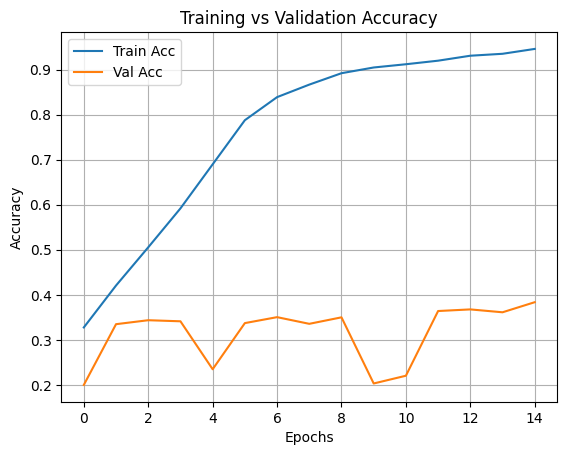

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Dataset directories
base_dir = "E:/preprocessed_dataset"
subfolders = {
    "colon_image_sets": ["colon_aca", "colon_n"],
    "lung_image_sets": ["lung_aca", "lung_n", "lung_scc"]
}

image_size = (64, 64)
X, y = [], []

# Load images
for parent_folder, class_list in subfolders.items():
    for cls in class_list:
        folder_path = os.path.join(base_dir, parent_folder, cls)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                X.append(np.array(img))
                y.append(cls)

# Convert to numpy arrays
X = np.array(X, dtype='float32') / 255.0
y = np.array(y)

# Label encode
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n✅ Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Setup
image_size = (64, 64)  # adjust as needed
base_dir = r"E:\preprocessed_dataset"
class_dirs = {
    "colon_aca": os.path.join(base_dir, "colon_image_sets", "colon_aca"),
    "colon_n": os.path.join(base_dir, "colon_image_sets", "colon_n"),
    "lung_aca": os.path.join(base_dir, "lung_image_sets", "lung_aca"),
    "lung_n": os.path.join(base_dir, "lung_image_sets", "lung_n"),
    "lung_scc": os.path.join(base_dir, "lung_image_sets", "lung_scc")
}

# Load data
data, labels = [], []

for label, folder in class_dirs.items():
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(folder, file)).convert('L')
            img = img.resize(image_size)
            data.append(np.array(img))
            labels.append(label)

# Preprocessing
X = np.expand_dims(np.array(data), -1) / 255.0  # normalize & add channel
y = LabelEncoder().fit_transform(labels)
y_cat = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Hybrid Model: CNN + LSTM + Transformer
from tensorflow.keras import layers, models

def transformer_encoder(inputs, num_heads=2, ff_dim=128):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    x = layers.Add()([x, attn_output])
    ffn = tf.keras.Sequential([
        layers.Dense(ff_dim, activation='relu'),
        layers.Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(x)
    return layers.Add()([x, ffn_output])

input_layer = tf.keras.Input(shape=(64, 64, 1))

# CNN Layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Reshape for LSTM
x = layers.Reshape((16, 256))(x)  # (batch, time, features)
x = layers.LSTM(64, return_sequences=True)(x)

# Transformer
x = transformer_encoder(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(y_cat.shape[1], activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# Classification report
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [16, 16, 64], output_shape = [16, 256]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 16, 16, 64), dtype=float32)

In [5]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import os

# Load dataset
def load_data(dataset_root, classes, image_size=(32, 32)):
    data, labels = [], []
    for cls in classes:
        cls_path = os.path.join(dataset_root, cls)
        for file in os.listdir(cls_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = Image.open(os.path.join(cls_path, file)).convert('L').resize(image_size)
                data.append(np.array(img).flatten())
                labels.append(cls)
    return np.array(data, dtype=np.float32), np.array(labels)

# Define ESN in PyTorch
class PyTorchESN(nn.Module):
    def __init__(self, input_size, reservoir_size=500, spectral_radius=0.9, sparsity=0.2):
        super(PyTorchESN, self).__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size

        self.Win = torch.randn(reservoir_size, input_size) * 0.1
        W = torch.randn(reservoir_size, reservoir_size)
        mask = torch.rand(reservoir_size, reservoir_size) < sparsity
        W *= mask.float()
        eigvals = torch.linalg.eigvals(W).abs()
        W *= spectral_radius / eigvals.max()
        self.W = W

        self.readout = nn.Linear(reservoir_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        state = torch.zeros(batch_size, self.reservoir_size)

        for i in range(x.size(1)):
            u = x[:, i]
            preact = torch.matmul(u.unsqueeze(1), self.Win.T) + torch.matmul(state, self.W.T)
            state = torch.tanh(preact)

        out = self.readout(state)
        return out

# Path and class setup
dataset_path = r"E:\preprocessed_dataset"
classes = [
    os.path.join('colon_image_sets', 'colon_aca'),
    os.path.join('colon_image_sets', 'colon_n'),
    os.path.join('lung_image_sets', 'lung_aca'),
    os.path.join('lung_image_sets', 'lung_n'),
    os.path.join('lung_image_sets', 'lung_scc')
]

# Load and preprocess
X, y = load_data(dataset_path, classes)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train).view(-1, X.shape[1])
X_test_tensor = torch.tensor(X_test).view(-1, X.shape[1])
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize and train ESN
model = PyTorchESN(input_size=X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    pred_outputs = model(X_test_tensor)
    pred_labels = (pred_outputs > 0.5).int().view(-1).numpy()
    print("✅ Accuracy:", accuracy_score(y_test, pred_labels))
    print("\n📊 Classification Report:\n", classification_report(y_test, pred_labels, target_names=le.classes_))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x1 and 1024x500)

Epoch 1/30
313/313 [==============================] - 54s 162ms/step - loss: 1.4495 - accuracy: 0.3442 - val_loss: 2.3274 - val_accuracy: 0.2008 - lr: 0.0010
Epoch 2/30
313/313 [==============================] - 51s 162ms/step - loss: 1.3382 - accuracy: 0.3890 - val_loss: 1.3025 - val_accuracy: 0.4032 - lr: 0.0010
Epoch 3/30
313/313 [==============================] - 51s 162ms/step - loss: 1.2936 - accuracy: 0.4120 - val_loss: 1.5065 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 4/30
313/313 [==============================] - 50s 161ms/step - loss: 1.2430 - accuracy: 0.4296 - val_loss: 1.2840 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 5/30
313/313 [==============================] - 50s 159ms/step - loss: 1.1963 - accuracy: 0.4517 - val_loss: 1.9847 - val_accuracy: 0.3364 - lr: 0.0010
Epoch 6/30
313/313 [==============================] - 50s 160ms/step - loss: 1.1623 - accuracy: 0.4748 - val_loss: 2.0543 - val_accuracy: 0.2592 - lr: 0.0010
Epoch 7/30
313/313 [==============================] 

D:\anconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 4s 39ms/step

✅ Classification Report:

              precision    recall  f1-score   support

   colon_aca       0.37      0.08      0.13       500
     colon_n       0.35      0.14      0.20       500
    lung_aca       0.39      0.41      0.40       500
      lung_n       0.81      0.83      0.82       500
    lung_scc       0.30      0.69      0.42       500

    accuracy                           0.43      2500
   macro avg       0.44      0.43      0.39      2500
weighted avg       0.44      0.43      0.39      2500



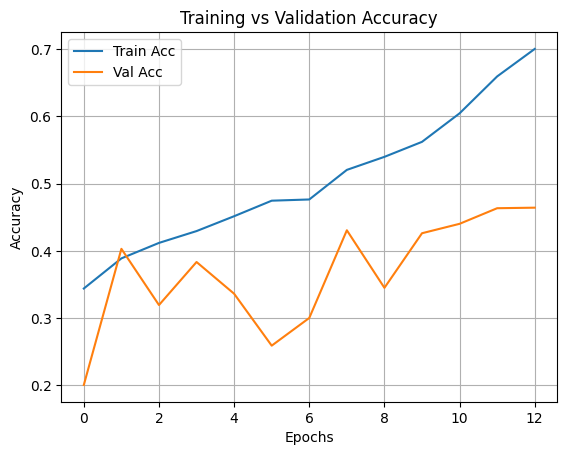

In [8]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, Reshape, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Dataset setup
base_dir = "E:/preprocessed_dataset"
subfolders = {
    "colon_image_sets": ["colon_aca", "colon_n"],
    "lung_image_sets": ["lung_aca", "lung_n", "lung_scc"]
}

image_size = (64, 64)
X, y = [], []

# Load images
for parent_folder, class_list in subfolders.items():
    for cls in class_list:
        folder_path = os.path.join(base_dir, parent_folder, cls)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                X.append(np.array(img))
                y.append(cls)

# Convert & normalize
X = np.array(X, dtype='float32') / 255.0
y = np.array(y)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Input shape
input_shape = (*image_size, 3)

# Model architecture
input_layer = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Flatten spatial dimensions into sequence for LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.5)(x)

output = Dense(len(encoder.classes_), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Save the model
model.save("hybrid_cnn_lstm_model.h5")

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n✅ Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Path to a single image
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image
model = load_model("hybrid_cnn_lstm_model.h5")

image_path = "E:\preprocessed_dataset\lung_image_sets\lung_aca\lungaca191.jpeg"

# Preprocess
img = Image.open(image_path).convert('RGB')
img = img.resize(image_size)
img_array = np.expand_dims(np.array(img, dtype='float32') / 255.0, axis=0)

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
pred_label = encoder.classes_[pred_class]

print(f"📸 Predicted class: {pred_label}")


1/1 [==============================] - 1s 548ms/step
📸 Predicted class: lung_scc


In [13]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image

# Load the saved model
model = load_model("hybrid_cnn_lstm_model.h5")

# Define paths and classes (same as training)
base_dir = "E:/preprocessed_dataset"
subfolders = {
    "colon_image_sets": ["colon_aca", "colon_n"],
    "lung_image_sets": ["lung_aca", "lung_n", "lung_scc"]
}
image_size = (64, 64)

X_test, y_test = [], []
for parent_folder, class_list in subfolders.items():
    for cls in class_list:
        folder_path = os.path.join(base_dir, parent_folder, cls)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                X_test.append(np.array(img))
                y_test.append(cls)

X_test = np.array(X_test, dtype='float32') / 255.0

# Label encode
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_test)
y_test_cat = to_categorical(y_encoded)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Report
print("✅ Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))


391/391 [==============================] - 16s 40ms/step
✅ Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.45      0.11      0.17      2500
     colon_n       0.45      0.18      0.25      2500
    lung_aca       0.43      0.45      0.44      2500
      lung_n       0.85      0.84      0.84      2500
    lung_scc       0.32      0.75      0.45      2500

    accuracy                           0.46     12500
   macro avg       0.50      0.46      0.43     12500
weighted avg       0.50      0.46      0.43     12500



In [22]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import random

# Echo State Network
class EchoStateNetwork:
    def __init__(self, input_size, reservoir_size, output_size, sparsity=0.1, spectral_radius=0.9):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.sparsity = sparsity
        self.spectral_radius = spectral_radius

        self.Win = np.random.rand(reservoir_size, input_size) * 2 - 1
        self.W = self._initialize_reservoir(reservoir_size, sparsity, spectral_radius)
        self.W_out = None

    def _initialize_reservoir(self, size, sparsity, spectral_radius):
        W = np.random.rand(size, size) - 0.5
        mask = np.random.rand(size, size) < sparsity
        W *= mask
        radius = max(abs(np.linalg.eigvals(W)))
        W *= spectral_radius / radius
        return W

    def _update_reservoir(self, input_data):
        states = []
        x = np.zeros(self.reservoir_size)
        for u in input_data:
            x = np.tanh(np.dot(self.Win, u) + np.dot(self.W, x))
            states.append(x)
        return np.array(states)

    def fit(self, input_data, target_data):
        states = self._update_reservoir(input_data)
        self.W_out = np.dot(np.linalg.pinv(states), target_data)

    def predict(self, input_data):
        states = self._update_reservoir(input_data)
        output = np.dot(states, self.W_out)
        return 1 / (1 + np.exp(-output))  # sigmoid

# Tuna Swarm Algorithm
class TunaSwarmOptimizer:
    def __init__(self, n_agents, n_iterations, param_bounds, X_train, y_train, X_val, y_val):
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.param_bounds = param_bounds
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def _evaluate(self, reservoir_size, sparsity):
        esn = EchoStateNetwork(input_size=self.X_train.shape[1], reservoir_size=reservoir_size,
                               output_size=1, sparsity=sparsity)
        esn.fit(self.X_train, self.y_train)
        y_pred = esn.predict(self.X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)
        return f1_score(self.y_val, y_pred_binary)

    def optimize(self):
        agents = [
            {
                'reservoir_size': random.randint(*self.param_bounds['reservoir_size']),
                'sparsity': random.uniform(*self.param_bounds['sparsity'])
            } for _ in range(self.n_agents)
        ]

        best_score = -1
        best_params = None

        for it in range(self.n_iterations):
            print(f"\u2699\ufe0f  Iteration {it+1}/{self.n_iterations}")
            for i, agent in enumerate(agents):
                score = self._evaluate(agent['reservoir_size'], agent['sparsity'])
                print(f"   Agent {i+1}: Reservoir={agent['reservoir_size']}, Sparsity={agent['sparsity']:.3f}, Score={score:.4f}")
                if score > best_score:
                    best_score = score
                    best_params = agent
        return best_params, best_score

# Load and preprocess dataset
def load_dataset(folder1, folder2, image_size=(64, 64)):
    images = []
    labels = []

    for filename in os.listdir(folder1):
        img_path = os.path.join(folder1, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size).flatten()
            images.append(img)
            labels.append(0)

    for filename in os.listdir(folder2):
        img_path = os.path.join(folder2, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size).flatten()
            images.append(img)
            labels.append(1)

    return np.array(images), np.array(labels)

# === Main Script ===
colon_n = "E:\preprocessed_dataset\colon_image_sets\colon_aca"
colon_aca = "E:\preprocessed_dataset\colon_image_sets\colon_n"
X, y = load_dataset(colon_n, colon_aca)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Optimize
tsa = TunaSwarmOptimizer(
    n_agents=10,
    n_iterations=20,
    param_bounds={'reservoir_size': (100, 1000), 'sparsity': (0.05, 0.9)},
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test
)
best_params, best_score = tsa.optimize()
print(f"\n✅ Best Params from TSA: Reservoir={best_params['reservoir_size']}, Sparsity={best_params['sparsity']:.3f}")

# Final evaluation
esn_final = EchoStateNetwork(input_size=X_train.shape[1],
                             reservoir_size=best_params['reservoir_size'],
                             output_size=1,
                             sparsity=best_params['sparsity'])
esn_final.fit(X_train, y_train)
y_pred_proba = esn_final.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Final Evaluation:")
print("✅ ESN Accuracy (Optimized with TSA):", np.mean(y_pred == y_test))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


⚙️  Iteration 1/20
   Agent 1: Reservoir=959, Sparsity=0.464, Score=0.4435
   Agent 2: Reservoir=736, Sparsity=0.371, Score=0.4650
   Agent 3: Reservoir=978, Sparsity=0.240, Score=0.4413
   Agent 4: Reservoir=396, Sparsity=0.239, Score=0.4785
   Agent 5: Reservoir=115, Sparsity=0.844, Score=0.5098
   Agent 6: Reservoir=965, Sparsity=0.355, Score=0.4513
   Agent 7: Reservoir=296, Sparsity=0.675, Score=0.4723
   Agent 8: Reservoir=591, Sparsity=0.713, Score=0.4990
   Agent 9: Reservoir=293, Sparsity=0.707, Score=0.4679
   Agent 10: Reservoir=795, Sparsity=0.279, Score=0.4637
⚙️  Iteration 2/20
   Agent 1: Reservoir=959, Sparsity=0.464, Score=0.4340
   Agent 2: Reservoir=736, Sparsity=0.371, Score=0.4659
   Agent 3: Reservoir=978, Sparsity=0.240, Score=0.4769
   Agent 4: Reservoir=396, Sparsity=0.239, Score=0.4886
   Agent 5: Reservoir=115, Sparsity=0.844, Score=0.4954
   Agent 6: Reservoir=965, Sparsity=0.355, Score=0.4308
   Agent 7: Reservoir=296, Sparsity=0.675, Score=0.4599
   Agent 

KeyboardInterrupt: 

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simulate data (replace with actual image features)
np.random.seed(42)
X = np.random.rand(5000, 100)  # 5000 samples, 100 features
y = np.array([np.random.choice(['Normal', 'Cancer']) for _ in range(5000)])

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Define ESN model
class ESN(nn.Module):
    def __init__(self, input_dim, reservoir_size, sparsity):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.W_in = torch.randn(reservoir_size, input_dim)
        mask = (torch.rand(reservoir_size, reservoir_size) < sparsity).float()
        self.W = torch.randn(reservoir_size, reservoir_size) * mask
        self.fc = nn.Linear(reservoir_size, 2)

    def forward(self, x):
        x = torch.FloatTensor(x)
        state = torch.zeros(self.reservoir_size)
        for i in range(x.shape[0]):
            state = torch.tanh(self.W_in @ x[i] + self.W @ state)
        out = self.fc(state)
        return F.softmax(out, dim=0)

# Evaluation function
def evaluate(model, X, y):
    preds = []
    for sample in X:
        out = model(sample.reshape(1, -1))
        preds.append(torch.argmax(out).item())
    acc = accuracy_score(y, preds)
    report = classification_report(y, preds, target_names=le.classes_)
    cm = confusion_matrix(y, preds)
    auc = roc_auc_score(y, preds)
    return acc, report, cm, auc

# Instantiate and test
input_dim = X.shape[1]
reservoir_size = 1000  # you can increase this for better performance with large data
sparsity = 0.3

model = ESN(input_dim, reservoir_size, sparsity)

# Evaluate on all sets
train_acc, train_report, train_cm, train_auc = evaluate(model, X_train, y_train)
val_acc, val_report, val_cm, val_auc = evaluate(model, X_val, y_val)
test_acc, test_report, test_cm, test_auc = evaluate(model, X_test, y_test)

# Output results
print("\n✅ Train Accuracy:", train_acc)
print(train_report)
print("Confusion Matrix (Train):\n", train_cm)

print("\n✅ Validation Accuracy:", val_acc)
print(val_report)
print("Confusion Matrix (Validation):\n", val_cm)

print("\n✅ Test Accuracy:", test_acc)
print(test_report)
print("Confusion Matrix (Test):\n", test_cm)

print("\nAUC-ROC (Validation):", val_auc)



✅ Train Accuracy: 0.495
              precision    recall  f1-score   support

      Cancer       0.49      0.61      0.54      1487
      Normal       0.50      0.38      0.43      1513

    accuracy                           0.49      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.50      0.49      0.49      3000

Confusion Matrix (Train):
 [[906 581]
 [934 579]]

✅ Validation Accuracy: 0.503
              precision    recall  f1-score   support

      Cancer       0.50      0.61      0.55       496
      Normal       0.51      0.40      0.45       504

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000

Confusion Matrix (Validation):
 [[303 193]
 [304 200]]

✅ Test Accuracy: 0.501
              precision    recall  f1-score   support

      Cancer       0.50      0.62      0.55       496
      Normal       0.51      0.38      0.43       504

In [24]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Dataset setup
base_dir = "E:/preprocessed_dataset"
subfolders = {
    "colon_image_sets": ["colon_aca", "colon_n"],
    "lung_image_sets": ["lung_aca", "lung_n", "lung_scc"]
}

image_size = (224, 224)  # VGG16 requires 224x224 input size
X, y = [], []

# Load images
for parent_folder, class_list in subfolders.items():
    for cls in class_list:
        folder_path = os.path.join(base_dir, parent_folder, cls)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                X.append(np.array(img))
                y.append(cls)

# Convert & normalize
X = np.array(X, dtype='float32') / 255.0
y = np.array(y)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Load pre-trained VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Freeze the base model layers
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(vgg16_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(encoder.classes_), activation='softmax')(x)

model = Model(inputs=vgg16_base.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Save the model
model.save("vgg16_finetuned_model.h5")

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n✅ Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

MemoryError: Unable to allocate 7.01 GiB for an array with shape (12500, 224, 224, 3) and data type float32

In [28]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# -------------------------
# Step 1: Load Image Dataset
# -------------------------

def load_images_from_folder(folder, image_size=(64, 64)):
    images, labels = [], []
    for label in os.listdir(folder):
        class_dir = os.path.join(folder, label)
        if not os.path.isdir(class_dir):
            continue
        for filename in tqdm(os.listdir(class_dir), desc=f"Loading {label}"):
            filepath = os.path.join(class_dir, filename)
            try:
                img = Image.open(filepath).convert('L')  # grayscale
                img = img.resize(image_size)
                img = np.array(img).flatten() / 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
    return np.array(images), np.array(labels)

# Replace with your actual dataset path
dataset_path = "E:\lung_colon_image_set"  # e.g., "./data" where folders like colon/cancer, colon/normal, etc. exist
X, y = load_images_from_folder(dataset_path)

# -------------------------------
# Step 2: Encode Labels & Split
# -------------------------------

class_names = np.unique(y)  # Save original class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ------------------------
# Step 3: Define ESN Model
# ------------------------

class ESN(nn.Module):
    def __init__(self, input_dim, reservoir_size, sparsity, output_dim):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.W_in = torch.randn(reservoir_size, input_dim)
        mask = (torch.rand(reservoir_size, reservoir_size) < sparsity).float()
        self.W = torch.randn(reservoir_size, reservoir_size) * mask
        self.fc = nn.Linear(reservoir_size, output_dim)

    def forward(self, x):
        x = torch.FloatTensor(x)
        state = torch.zeros(self.reservoir_size)
        for i in range(x.shape[0]):
            state = torch.tanh(self.W_in @ x[i] + self.W @ state)
        out = self.fc(state)
        return F.softmax(out, dim=0)

# ------------------------------
# Step 4: Evaluation Function
# ------------------------------

def evaluate(model, X, y, class_names):
    preds = []
    for sample in X:
        out = model(sample.reshape(1, -1))
        preds.append(torch.argmax(out).item())
    acc = accuracy_score(y, preds)
    report = classification_report(y, preds, target_names=class_names)
    cm = confusion_matrix(y, preds)
    auc = roc_auc_score(y, preds, multi_class="ovr")  # handles multiclass
    return acc, report, cm, auc

# --------------------------
# Step 5: Train and Evaluate
# --------------------------

start_time = time.time()

input_dim = X.shape[1]
reservoir_size = 1000
sparsity = 0.2
output_dim = len(np.unique(y_encoded))

model = ESN(input_dim=input_dim, reservoir_size=reservoir_size, sparsity=sparsity, output_dim=output_dim)

train_acc, train_report, train_cm, train_auc = evaluate(model, X_train, y_train, class_names)
val_acc, val_report, val_cm, val_auc = evaluate(model, X_val, y_val, class_names)
test_acc, test_report, test_cm, test_auc = evaluate(model, X_test, y_test, class_names)

# ------------------------
# Step 6: Display Results
# ------------------------

print("\n✅ Train Accuracy:", train_acc)
print(train_report)
print("Confusion Matrix (Train):\n", train_cm)

print("\n✅ Validation Accuracy:", val_acc)
print(val_report)
print("Confusion Matrix (Validation):\n", val_cm)

print("\n✅ Test Accuracy:", test_acc)
print(test_report)
print("Confusion Matrix (Test):\n", test_cm)

print("\nAUC-ROC (Validation):", val_auc)
print(f"\n⏱️ Total Execution Time: {time.time() - start_time:.2f} seconds")


Loading colon_n: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [01:02<00:00, 80.17it/s]



✅ Train Accuracy: 0.4955
              precision    recall  f1-score   support

   colon_aca       0.50      0.88      0.63      3000
     colon_n       0.48      0.11      0.18      3000

    accuracy                           0.50      6000
   macro avg       0.49      0.50      0.41      6000
weighted avg       0.49      0.50      0.41      6000

Confusion Matrix (Train):
 [[2630  370]
 [2657  343]]

✅ Validation Accuracy: 0.511
              precision    recall  f1-score   support

   colon_aca       0.51      0.89      0.64      1000
     colon_n       0.54      0.14      0.22      1000

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.43      2000
weighted avg       0.52      0.51      0.43      2000

Confusion Matrix (Validation):
 [[885 115]
 [863 137]]

✅ Test Accuracy: 0.4865
              precision    recall  f1-score   support

   colon_aca       0.49      0.86      0.63      1000
     colon_n       0.45      0.11      0.18    

In [30]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from torchvision import transforms
from PIL import Image

# ---------------------------
# Load Image Dataset
# ---------------------------
def load_dataset(root_dir, image_size=(64, 64)):
    X, y = [], []
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    for label in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = transform(img)
                    X.append(img_tensor.numpy().flatten())
                    y.append(label)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")

    return np.array(X), np.array(y)

# Load your colon dataset
root_dir = r"E:\lung_colon_image_set"
X, y = load_dataset(root_dir)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-7)

# Stratified split: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ---------------------------
# ESN Model with Classifier Head
# ---------------------------
class ESN(nn.Module):
    def __init__(self, input_dim, reservoir_size=1000, sparsity=0.3, output_dim=2):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.W_in = torch.randn(reservoir_size, input_dim) * 0.1
        mask = (torch.rand(reservoir_size, reservoir_size) < sparsity).float()
        self.W = torch.randn(reservoir_size, reservoir_size) * mask * 0.1
        
        # Classifier head - MLP
        self.fc = nn.Sequential(
            nn.Linear(reservoir_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = torch.FloatTensor(x)
        state = torch.zeros(self.reservoir_size)
        for i in range(x.shape[0]):
            state = torch.tanh(self.W_in @ x[i] + self.W @ state)
        out = self.fc(state)
        return F.softmax(out, dim=0)

# ---------------------------
# Evaluation
# ---------------------------
def evaluate(model, X, y):
    preds = []
    for sample in X:
        out = model(sample.reshape(1, -1))
        preds.append(torch.argmax(out).item())
    
    acc = accuracy_score(y, preds)
    report = classification_report(y, preds, target_names=le.classes_)
    cm = confusion_matrix(y, preds)
    try:
        auc = roc_auc_score(y, preds, multi_class='ovr')
    except:
        auc = None
    return acc, report, cm, auc

# ---------------------------
# Train & Evaluate
# ---------------------------
start = time.time()

input_dim = X.shape[1]
output_dim = len(np.unique(y))
reservoir_size = 1000
sparsity = 0.3

model = ESN(input_dim=input_dim, reservoir_size=reservoir_size, sparsity=sparsity, output_dim=output_dim)

# Evaluate model
train_acc, train_report, train_cm, train_auc = evaluate(model, X_train, y_train)
val_acc, val_report, val_cm, val_auc = evaluate(model, X_val, y_val)
test_acc, test_report, test_cm, test_auc = evaluate(model, X_test, y_test)

end = time.time()

# ---------------------------
# Output
# ---------------------------
print("\n✅ Train Accuracy:", train_acc)
print(train_report)
print("Confusion Matrix (Train):\n", train_cm)

print("\n✅ Validation Accuracy:", val_acc)
print(val_report)
print("Confusion Matrix (Validation):\n", val_cm)

print("\n✅ Test Accuracy:", test_acc)
print(test_report)
print("Confusion Matrix (Test):\n", test_cm)

if val_auc is not None:
    print("\nAUC-ROC (Validation):", val_auc)

print(f"\n⏱️ Total Execution Time: {end - start:.2f} seconds")



✅ Train Accuracy: 0.49316666666666664
              precision    recall  f1-score   support

   colon_aca       0.49      0.60      0.54      3000
     colon_n       0.49      0.39      0.43      3000

    accuracy                           0.49      6000
   macro avg       0.49      0.49      0.49      6000
weighted avg       0.49      0.49      0.49      6000

Confusion Matrix (Train):
 [[1794 1206]
 [1835 1165]]

✅ Validation Accuracy: 0.4865
              precision    recall  f1-score   support

   colon_aca       0.49      0.60      0.54      1000
     colon_n       0.48      0.37      0.42      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.49      0.49      0.48      2000

Confusion Matrix (Validation):
 [[603 397]
 [630 370]]

✅ Test Accuracy: 0.48
              precision    recall  f1-score   support

   colon_aca       0.48      0.58      0.53      1000
     colon_n       0.48      0.38  

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import time
import os
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ---------------------------
# Load Image Dataset
# ---------------------------
def load_dataset(root_dir, image_size=(64, 64)):
    X, y = [], []
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    for label in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = transform(img)
                    X.append(img_tensor.numpy().flatten())
                    y.append(label)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
    return np.array(X), np.array(y)

# ---------------------------
# ESN Feature Extractor
# ---------------------------
class ESNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, reservoir_size=1000, sparsity=0.3):
        super(ESNFeatureExtractor, self).__init__()
        self.reservoir_size = reservoir_size
        self.W_in = torch.randn(reservoir_size, input_dim) * 0.1
        mask = (torch.rand(reservoir_size, reservoir_size) < sparsity).float()
        self.W = torch.randn(reservoir_size, reservoir_size) * mask * 0.1

    def forward(self, x):
        x = torch.FloatTensor(x)
        state = torch.zeros(self.reservoir_size)
        for i in range(x.shape[0]):
            state = torch.tanh(self.W_in @ x[i] + self.W @ state)
        return state

# ---------------------------
# MLP Classifier
# ---------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=0)

# ---------------------------
# Particle Swarm Optimization
# ---------------------------
def flatten_weights(model):
    return torch.cat([p.flatten() for p in model.parameters()])

def unflatten_weights(model, flat_weights):
    idx = 0
    for param in model.parameters():
        param_len = param.numel()
        param.data = flat_weights[idx:idx + param_len].reshape(param.shape).clone()
        idx += param_len

def fitness(model, features, targets):
    preds = []
    for f in features:
        out = model(f)
        preds.append(torch.argmax(out).item())
    return 1 - accuracy_score(targets, preds)

def pso_optimize(model, features, targets, n_particles=10, n_iters=20, w=0.7, c1=1.4, c2=1.4):
    dim = flatten_weights(model).shape[0]
    particles = [torch.randn(dim) for _ in range(n_particles)]
    velocities = [torch.zeros(dim) for _ in range(n_particles)]
    personal_best = particles.copy()
    personal_best_scores = [fitness(model, features, targets) for _ in range(n_particles)]
    global_best = personal_best[np.argmin(personal_best_scores)]

    for _ in range(n_iters):
        for i in range(n_particles):
            r1, r2 = torch.rand(dim), torch.rand(dim)
            velocities[i] = (w * velocities[i] + 
                             c1 * r1 * (personal_best[i] - particles[i]) + 
                             c2 * r2 * (global_best - particles[i]))
            particles[i] += velocities[i]
            unflatten_weights(model, particles[i])
            score = fitness(model, features, targets)
            if score < personal_best_scores[i]:
                personal_best[i] = particles[i].clone()
                personal_best_scores[i] = score
        global_best = personal_best[np.argmin(personal_best_scores)]
    return global_best

# ---------------------------
# Run Experiment
# ---------------------------
start = time.time()

# Load dataset
root_dir = r"E:\lung_colon_image_set"
X, y = load_dataset(root_dir)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-7)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create ESN
input_dim = X.shape[1]
esn = ESNFeatureExtractor(input_dim=input_dim)

# Get reservoir outputs
reservoir_train = [esn(x.reshape(1, -1)) for x in X_train]
reservoir_val = [esn(x.reshape(1, -1)) for x in X_val]
reservoir_test = [esn(x.reshape(1, -1)) for x in X_test]

# Train MLP using PSO
mlp = MLP(input_dim=esn.reservoir_size, hidden_dim=128, output_dim=len(le.classes_))
best_weights = pso_optimize(mlp, reservoir_train, y_train)
unflatten_weights(mlp, best_weights)

# Evaluation
def evaluate_phase(mlp, data, targets):
    preds = []
    for x in data:
        out = mlp(x)
        preds.append(torch.argmax(out).item())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=le.classes_)
    cm = confusion_matrix(targets, preds)
    try:
        auc = roc_auc_score(targets, preds, multi_class='ovr')
    except:
        auc = None
    return acc, report, cm, auc

train_acc, train_report, train_cm, train_auc = evaluate_phase(mlp, reservoir_train, y_train)
val_acc, val_report, val_cm, val_auc = evaluate_phase(mlp, reservoir_val, y_val)
test_acc, test_report, test_cm, test_auc = evaluate_phase(mlp, reservoir_test, y_test)

end = time.time()

# Print results
print(f"\n✅ Train Accuracy: {train_acc}\n{train_report}")
print("Confusion Matrix (Train):\n", train_cm)

print(f"\n✅ Validation Accuracy: {val_acc}\n{val_report}")
print("Confusion Matrix (Validation):\n", val_cm)

print(f"\n✅ Test Accuracy: {test_acc}\n{test_report}")
print("Confusion Matrix (Test):\n", test_cm)

if val_auc:
    print("AUC-ROC (Validation):", val_auc)

print(f"\n⏱️ Total Execution Time: {end - start:.2f} seconds")



✅ Train Accuracy: 0.4056666666666667
              precision    recall  f1-score   support

   colon_aca       0.41      0.43      0.42      3000
     colon_n       0.40      0.38      0.39      3000

    accuracy                           0.41      6000
   macro avg       0.41      0.41      0.41      6000
weighted avg       0.41      0.41      0.41      6000

Confusion Matrix (Train):
 [[1284 1716]
 [1850 1150]]

✅ Validation Accuracy: 0.424
              precision    recall  f1-score   support

   colon_aca       0.43      0.45      0.44      1000
     colon_n       0.42      0.40      0.41      1000

    accuracy                           0.42      2000
   macro avg       0.42      0.42      0.42      2000
weighted avg       0.42      0.42      0.42      2000

Confusion Matrix (Validation):
 [[450 550]
 [602 398]]

✅ Test Accuracy: 0.4065
              precision    recall  f1-score   support

   colon_aca       0.41      0.43      0.42      1000
     colon_n       0.40      0.38  

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import time
import os
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torchvision.models import mobilenet_v2

# ---------------------------
# Load Image Dataset
# ---------------------------
def load_dataset(root_dir, image_size=(224, 224)):
    X, y = [], []
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    for label in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = transform(img)
                    X.append(img_tensor.numpy())
                    y.append(label)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
    return np.array(X), np.array(y)

# ---------------------------
# GhostNet Feature Extractor (Using MobileNetV2 as proxy)
# ---------------------------
class GhostNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(GhostNetFeatureExtractor, self).__init__()
        model = mobilenet_v2(pretrained=True)
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        return x

# ---------------------------
# Echo State Network Classifier
# ---------------------------
class ESNClassifier(nn.Module):
    def __init__(self, input_dim, reservoir_size=500, output_dim=3, sparsity=0.3):
        super(ESNClassifier, self).__init__()
        self.reservoir_size = reservoir_size
        self.output_dim = output_dim
        self.W_in = torch.randn(reservoir_size, input_dim) * 0.1
        mask = (torch.rand(reservoir_size, reservoir_size) < sparsity).float()
        self.W = torch.randn(reservoir_size, reservoir_size) * mask * 0.1
        self.fc = nn.Linear(reservoir_size, output_dim)

    def forward(self, x):
        x = torch.FloatTensor(x)
        x = (x - x.mean()) / (x.std() + 1e-6)
        state = torch.zeros(self.reservoir_size)
        for i in range(x.shape[0]):
            state = torch.tanh(self.W_in @ x[i] + self.W @ state)
        out = self.fc(state)
        return F.softmax(out, dim=-1)

# ---------------------------
# TSA Optimization
# ---------------------------
def flatten_weights(model):
    return torch.cat([p.flatten() for p in model.parameters()])

def unflatten_weights(model, flat_weights):
    idx = 0
    for param in model.parameters():
        param_len = param.numel()
        param.data = flat_weights[idx:idx + param_len].reshape(param.shape).clone()
        idx += param_len

def fitness(model, features, targets):
    pred_probs = torch.stack([model(f) for f in features])
    pred_classes = torch.argmax(pred_probs, dim=1)
    return 1 - accuracy_score(targets, pred_classes.numpy())

def tsa_optimize(model, features, targets, n_agents=20, n_iters=40, A=0.7, B=1.5):
    dim = flatten_weights(model).shape[0]
    agents = [torch.randn(dim) for _ in range(n_agents)]
    best_agents = agents.copy()
    best_scores = [fitness(model, features, targets) for _ in range(n_agents)]
    global_best = best_agents[np.argmin(best_scores)]

    for iter_ in range(n_iters):
        for i in range(n_agents):
            alpha = A * torch.rand(dim) * (1 - iter_ / n_iters)
            beta = B * torch.rand(dim) * (iter_ / n_iters)
            new_pos = agents[i] + alpha * (global_best - agents[i]) + beta * torch.randn(dim)
            agents[i] = new_pos
            unflatten_weights(model, agents[i])
            score = fitness(model, features, targets)
            if score < best_scores[i]:
                best_agents[i] = agents[i].clone()
                best_scores[i] = score
        global_best = best_agents[np.argmin(best_scores)]
    return global_best

# ---------------------------
# Run Experiment
# ---------------------------
start = time.time()

# Load dataset
root_dir = r"E:\\lung_colon_image_set"
X, y = load_dataset(root_dir)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Extract features using GhostNet
ghostnet = GhostNetFeatureExtractor()
torch_X = torch.tensor(X).float()
features = []
for i in range(0, len(torch_X), 10):  # batch processing
    batch = torch_X[i:i+10]
    feats = ghostnet(batch)
    features.append(feats.detach().numpy())
features = np.vstack(features)

# Apply PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(features)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create ESN Classifier
esn = ESNClassifier(input_dim=X_pca.shape[1], reservoir_size=600, output_dim=len(le.classes_))

# Train ESN using TSA
train_features = [x.reshape(1, -1) for x in X_train]
val_features = [x.reshape(1, -1) for x in X_val]
test_features = [x.reshape(1, -1) for x in X_test]

best_weights = tsa_optimize(esn, train_features, y_train)
unflatten_weights(esn, best_weights)

# Evaluation

def evaluate_phase(model, data, targets):
    preds = []
    for x in data:
        out = model(x)
        preds.append(torch.argmax(out).item())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=le.classes_)
    cm = confusion_matrix(targets, preds)
    try:
        auc = roc_auc_score(targets, preds, multi_class='ovr')
    except:
        auc = None
    return acc, report, cm, auc

train_acc, train_report, train_cm, train_auc = evaluate_phase(esn, train_features, y_train)
val_acc, val_report, val_cm, val_auc = evaluate_phase(esn, val_features, y_val)
test_acc, test_report, test_cm, test_auc = evaluate_phase(esn, test_features, y_test)

end = time.time()

# Print results
print(f"\n✅ Train Accuracy: {train_acc}\n{train_report}")
print("Confusion Matrix (Train):\n", train_cm)

print(f"\n✅ Validation Accuracy: {val_acc}\n{val_report}")
print("Confusion Matrix (Validation):\n", val_cm)

print(f"\n✅ Test Accuracy: {test_acc}\n{test_report}")
print("Confusion Matrix (Test):\n", test_cm)

if val_auc:
    print("AUC-ROC (Validation):", val_auc)

print(f"\n⏱️ Total Execution Time: {end - start:.2f} seconds")
